In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow as tf

In [2]:
from sklearn.model_selection import train_test_split

### Pré-Processamento e visualização das Imagens

In [14]:
def carregar_imagens(caminho, tamanho=(64,64)):
    imagens = []
    labels = []
    for pasta in os.listdir(caminho):
        classe = os.path.basename(pasta)
        for arquivo in os.listdir(os.path.join(caminho, pasta)):
            imagem = cv2.imread(os.path.join(caminho, pasta, arquivo))
            imagem = cv2.resize(imagem, tamanho)
            imagens.append(imagem)
            labels.append(int(classe))
    return np.array(imagens) / 255.0 , np.array(labels)

In [15]:
caminho = "./dataset"
imagens, labels = carregar_imagens(caminho)

In [16]:
imagens_treino, imagens_teste, labels_treino, labels_teste = train_test_split(imagens, labels, test_size=0.3, random_state=45)

In [17]:
np.savez('dataset.npz', imagens_treino=imagens_treino, labels_treino=labels_treino, imagens_teste=imagens_teste, labels_teste=labels_teste)

### Carregando os Dados

In [18]:
data = np.load('dataset.npz')
imagens_treino = data['imagens_treino']
labels_treino = data['labels_treino']
imagens_teste = data['imagens_teste']
labels_teste = data['labels_teste']

In [19]:
nomes_classes = ['Não é uma pessoa', 'pessoa']

In [20]:
print(imagens_teste)

[[[[0.85882353 0.90588235 0.92156863]
   [0.87843137 0.9254902  0.94117647]
   [0.89019608 0.9372549  0.94509804]
   ...
   [0.07843137 0.14117647 0.19215686]
   [0.11764706 0.17647059 0.23921569]
   [0.15294118 0.20784314 0.27843137]]

  [[0.88235294 0.92941176 0.94509804]
   [0.87843137 0.9254902  0.94117647]
   [0.8745098  0.9254902  0.93333333]
   ...
   [0.16078431 0.21568627 0.28627451]
   [0.13333333 0.18823529 0.25882353]
   [0.22352941 0.2745098  0.34117647]]

  [[0.87058824 0.92156863 0.92941176]
   [0.89019608 0.9372549  0.94509804]
   [0.88235294 0.92941176 0.9372549 ]
   ...
   [0.05882353 0.09411765 0.10588235]
   [0.09019608 0.15686275 0.19607843]
   [0.17647059 0.24705882 0.31372549]]

  ...

  [[0.20784314 0.29411765 0.39215686]
   [0.21176471 0.29019608 0.38823529]
   [0.23529412 0.3254902  0.42745098]
   ...
   [0.0745098  0.17647059 0.23137255]
   [0.10980392 0.23137255 0.29019608]
   [0.19215686 0.28627451 0.35294118]]

  [[0.21568627 0.27058824 0.36078431]
   [0.1

In [7]:
from PIL import Image

In [6]:
labels_teste.shape

(81,)

In [8]:
labels_teste

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
def visualiza_imagens(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

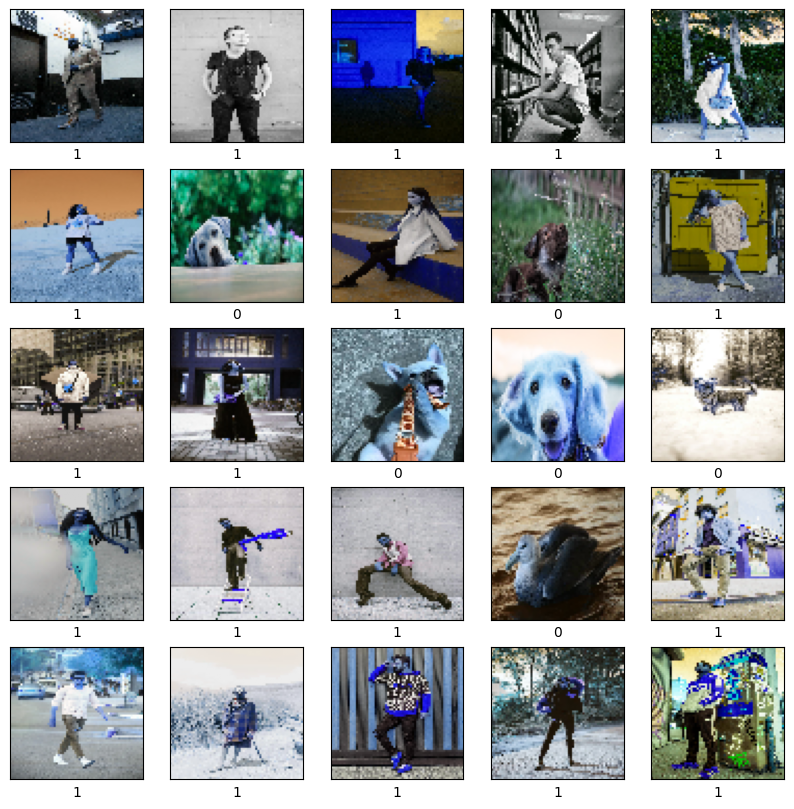

In [10]:
visualiza_imagens(imagens_teste, labels_teste)

### Construção do Modelo

In [37]:
# Modelo

# Criar o objeto de sequência de camadas
modelo = models.Sequential()

# Adiciona o primeiro bloco de convolução e max pooling (camada de entrada)
modelo.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64,64,3))) # (32,32) é os pixel da imagem e o 3 é o rgb
modelo.add(layers.MaxPooling2D((2,2)))

# Adicionando o segundo bloco de convolução e max pooling (camada intermediária)
modelo.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))

modelo.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))

modelo.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))

modelo.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))

modelo.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))




In [38]:
modelo.add(layers.Flatten())
modelo.add(layers.Dense(128, activation='relu'))
modelo.add(layers.Dense(2, activation='softmax'))

In [39]:
modelo.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,458 (1.26 MB)

 Trainable params: 331,458 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [41]:
%%time
history = modelo.fit(imagens_treino,
                    labels_treino,
                    epochs=20,
                    validation_data=(imagens_teste, labels_teste))

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7651 - loss: 0.6158 - val_accuracy: 0.7778 - val_loss: 0.5429
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7978 - loss: 0.5380 - val_accuracy: 0.7778 - val_loss: 0.4917
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7450 - loss: 0.5639 - val_accuracy: 0.7778 - val_loss: 0.4911
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7453 - loss: 0.5199 - val_accuracy: 0.7778 - val_loss: 0.4914
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8004 - loss: 0.4436 - val_accuracy: 0.7778 - val_loss: 0.4900
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7959 - loss: 0.4551 - val_accuracy: 0.7778 - val_loss: 0.4839
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7879 - loss: 0.4405 - val_accuracy: 0.7778 - val_loss: 0.4817
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7674 - loss: 0.4195 - val_accuracy: 0.7778 - val_loss: 0.4836


### Avaliação do Modelo

In [42]:
def prever(predict):
    classe_prevista = np.argmax(predict)
    return nomes_classes[classe_prevista]

In [43]:
erro_teste, acc_teste = modelo.evaluate(imagens_teste, labels_teste, verbose = 2)

3/3 - 0s - 22ms/step - accuracy: 0.8025 - loss: 0.7746


In [44]:
print('\nAcurácia com Dados de Teste:', acc_teste)


Acurácia com Dados de Teste: 0.8024691343307495


In [33]:
def previl_image(image):
    imagem_verifica = Image.open(image)
    imagem_verifica = imagem_verifica.resize((64,64))
    plt.figure(figsize = (1,1))
    plt.imshow(imagem_verifica)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print(imagem_verifica.size)
    imagem_verifica_np = np.array(imagem_verifica) / 255.0
    imagem_verifica_np = np.expand_dims(imagem_verifica_np, axis=0)

    predict = modelo.predict(imagem_verifica_np)
    print(predict)
    return prever(predict)

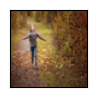

(64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
[[0.20112908 0.7988709 ]]


'pessoa'

In [45]:
previl_image("../images.jfif")

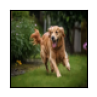

(64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.2017891  0.79821086]]


'pessoa'

In [46]:
previl_image("../c01.webp")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


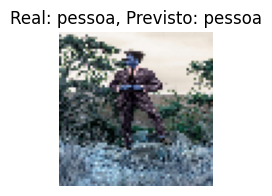

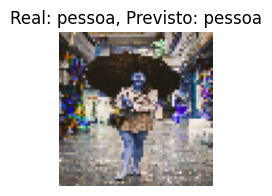

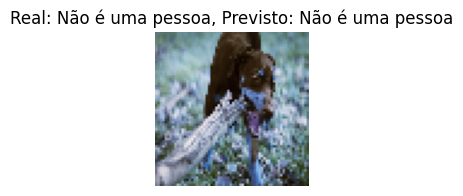

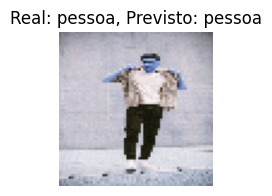

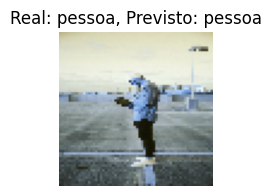

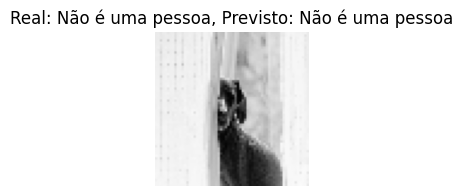

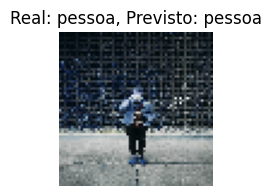

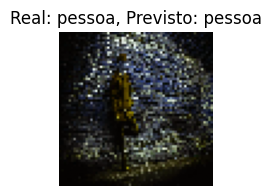

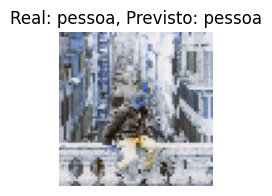

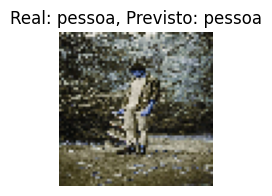

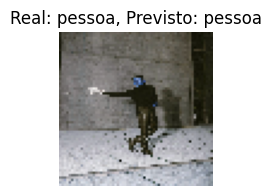

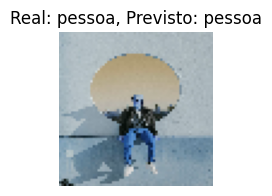

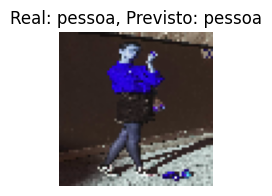

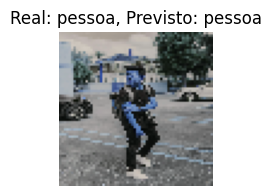

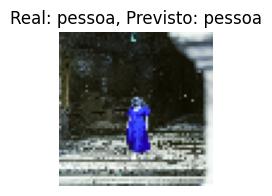

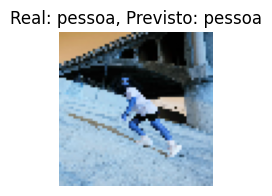

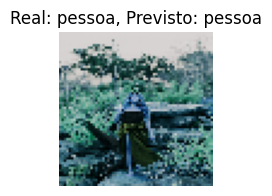

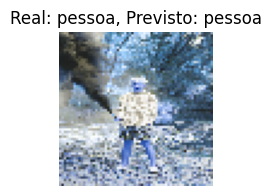

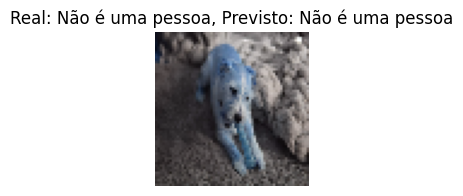

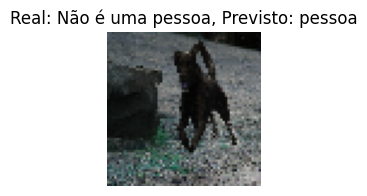

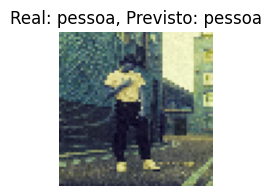

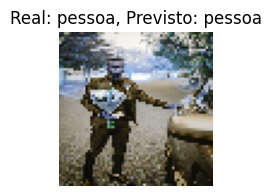

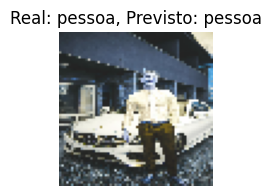

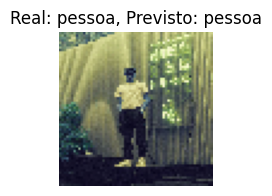

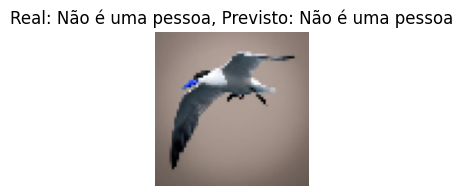

In [47]:
previsoes_treino = modelo.predict(imagens_treino)

# Mostrando os resultados das previsões
for i in range(25):
    imagem = imagens_treino[i]
    label_real = labels_treino[i]
    label_prevista = np.argmax(previsoes_treino[i])
    classe_prevista = nomes_classes[label_prevista]
    
    plt.figure(figsize=(2, 2))
    plt.imshow(imagem)
    plt.title(f'Real: {nomes_classes[label_real]}, Previsto: {classe_prevista}')
    plt.axis('off')
    plt.show()

In [48]:
modelo.save("modelo.h5")